In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

#%matplotlib notebook

In [2]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(50, 100, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(100, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(150, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(200, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(250, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/1000.0]*1000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(d[2], fs)] + [filt(x, fs) for x in d[4:9]] + [button])
    
    

In [3]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    
    en = np.array(np.where(xt == -1))[0]
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(6):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [4]:
files = ["b_front_" + str(i) + ".txt" for i in range(1,6)]
read_dat = [readFile(_) for _ in files]
feats_a = [extract_feat(_, feat) for _ in read_dat]

files = ["b_side_" + str(i) + ".txt" for i in range(1,6)]
read_dat = [readFile(_) for _ in files]
feats_b = [extract_feat(_, feat) for _ in read_dat]

files = ["b_back_" + str(i) + ".txt" for i in range(1,6)]
read_dat = [readFile(_) for _ in files]
feats_c = [extract_feat(_, feat) for _ in read_dat]

Reading: b_front_1.txt
Reading: b_front_2.txt
Reading: b_front_3.txt
Reading: b_front_4.txt
Reading: b_front_5.txt
64 64
79 79
73 73
89 89
88 88
Reading: b_side_1.txt
Reading: b_side_2.txt
Reading: b_side_3.txt
Reading: b_side_4.txt
Reading: b_side_5.txt
74 74
76 76
70 70
85 85
87 87
Reading: b_back_1.txt
Reading: b_back_2.txt
Reading: b_back_3.txt
Reading: b_back_4.txt
Reading: b_back_5.txt
79 79
100 100
125 125
125 125
153 153


In [5]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [6]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [7]:
feats_all = [feats_a, feats_b, feats_c]

print("A")

for i in feats_all:
    print("[", end = "")
    for j in feats_all:

        X_train, y_train = getXy(i, (0, 1, 2, 3, 4, 5), 2)
        X_test, y_test = getXy(j, (0, 1, 2, 3, 4, 5), 2)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        print(round(test_acc,2), end = ",\t")
    print("]")
    

A
[77.61,	67.35,	58.25,	]
[67.68,	75.0,	62.03,	]
[62.09,	65.82,	69.76,	]


<Figure size 360x288 with 0 Axes>

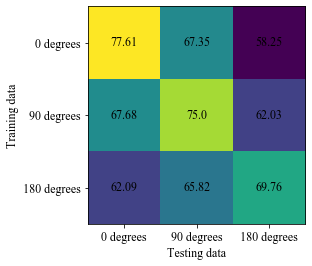

In [4]:
font = {'family' : 'Times New Roman ',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)

plt.figure(figsize=(5,4))

fig, ax = plt.subplots()

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels(["0 degrees", "90 degrees", "180 degrees"])
ax.set_yticklabels(["0 degrees", "90 degrees", "180 degrees"])

plt.xlabel("Testing data")
plt.ylabel("Training data")
#plt.title("Inter rotation training and testing")

res = [[77.61,	67.35,	58.25,	],
[67.68,	75.0,	62.03,	],
[62.09,	65.82,	69.76,	]]
plt.imshow(res)
for i in range(3):
    for j in range(3):
        text = plt.text(j, i, res[i][j],ha="center", va="center", color="black")


